In [4]:
import os,sys
import csv
import copy
import math

from IPython.display import Math
from IPython.display import Latex
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from clawpack import pyclaw

from scipy.integrate import simps, trapz


sys.path.append("/home/pgrover/Dropbox/PhD/Morphodynamic_Model/pymorph")
from weno import WENO,ENO
from weno import get_stencil
import sed_trans
from avalanche_scheme import *


%matplotlib inline
%load_ext autoreload
%autoreload 2

# WENO-ENO Third Test with Avalance Model

First set up the domain and initial conditions.

In [5]:
# Setup a domain with 500 nodes
nx=500
x = pyclaw.Dimension(0.0,100.0,nx,name='x')
domain = pyclaw.Domain(x)
state = pyclaw.State(domain,1)

 # Set constants 
Base_Bed_Elevation = 5.0
Mean_Water_Depth = 3.0

# Set the initial conditions
u_f = 1.0  
q_f= u_f*Mean_Water_Depth   

D0 = 1.1
alpha = 1.0

pm = 0.0 #get_bed_porosity(D0)

H = Base_Bed_Elevation + Mean_Water_Depth


# set the intial bed
# Based on eq 21 from Kubatko et al 2007
#state.q[0,:] = np.exp(-beta * (xc-x0)**2) * np.cos(gamma * (xc - x0)) + 10.0
A0 = Base_Bed_Elevation
A1 = 1
lamb = 20.
xc = state.grid.x.centers
dx = state.grid.delta[0]

z = A0 + A1*np.sin( (2.*math.pi*xc)/lamb )
zc = z.copy()

#eq 4
u = q_f/((Mean_Water_Depth+Base_Bed_Elevation) - z)
qbedload = np.zeros(nx)
flux=np.zeros(nx)

# from EQ 5 in Kubatko et al 2007

qbedload = alpha * u


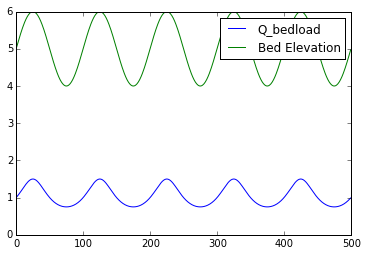

In [6]:
plt.plot(qbedload, label='Q_bedload')
plt.plot(z, label='Bed Elevation')
plt.legend()

## Setup the model run



In [7]:


nt = 50   # Number of time steps
dt = 0.1 # Time step size (s)

k = 3 # number of weights Order= 2*k-1

c=1

for n in range(1,nt):  
    zn = zc.copy() 
    for i in range(0,nx): #i=2
        xloc = xc[i-(k-1):i+k] #i+k-1-(i-(k-1)-1) = 2k -1 
        
        qloc = get_stencil(qbedload,i-(k-1),i+k)
        
        qloc_OLD = qbedload[i-(k-1):i+k]
        
        if len(qloc) <5:
            print('Problem qloc={0}  start={1} end={2}, len(qbedload)={3}'.format(qloc,i-(k-1),i+k,len(qbedload)))
        elif len(qloc) >5:
            print('Problem qloc={0}  start={1} end={2}, len(qbedload)={3}'.format(qloc,i-(k-1),i+k,len(qbedload)))

 
        f_left,f_right = WENO(xloc,qloc,k)
        #f_left,f_right = WENO(xloc,uloc,k)
        #upwind flux
        flux[i]=0.5*(c+abs(c))*f_left + 0.5*(c-abs(c))*f_right
        
    # Need the sign of the phase speed
    for i in range(0,nx): #i=2
        if c>0:
            zc[i] = zn[i]-(1./(1.-pm))*dt/dx*(flux[i]-flux[i-1])
        else:
            zc[i] = zn[i]-(1./(1.-pm))*dt/dx*(flux[i+1]-flux[i])
    
    qbedload = alpha * q_f/((Mean_Water_Depth+Base_Bed_Elevation) - zc)
    
    z_updated,iterations = avalanche_model(dx,xc,zc)
    
    if iterations > 1:
        zc = z_updated.copy()

fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(111)

plt.plot(xc,z,'r')
plt.plot(xc,zc)

IndexError: index 5 is out of bounds for axis 0 with size 5

In [8]:
slopes=np.zeros(len(xc))
for i in range(len(xc)):
    zloc = get_stencil(zc,i,i+2)
    slopes[i] =get_slope(dx, zloc)
print min(slopes)

-17.4378996788


In [9]:
area_old = trapz(z, dx=dx)
area_new = trapz(zc, dx=dx)  
print('Area old: {0} Area new: {1} Iterations: {2}'.format(area_old,area_new,iterations))

NameError: name 'iterations' is not defined

In [10]:
get_stencil(qbedload,-1,4)

array([ 0.98963824,  1.01058104,  1.03238535,  1.05501349,  1.07841642])

In [11]:
qbedload[0:3]

array([ 1.01058104,  1.03238535,  1.05501349])

In [12]:
gs = np.zeros((nx+2*gc,nt))
flux = np.zeros(nx+2*gc)

for n in range(1,nt):  
    un = uc.copy() 
    for i in range(gc,nx-1+gc): #i=2
        xloc = xc[i-(k-1):i+k] #i+k-1-(i-(k-1)-1) = 2k -1 
        uloc = uc[i-(k-1):i+k]
        f_left,f_right = ENO(xloc,uloc,k)
        #f_left,f_right = WENO(xloc,uloc,k)
        #upwind flux
        flux[i]=0.5*(c+abs(c))*f_left + 0.5*(c-abs(c))*f_right
    # Need the sign of the phase speed
    
    for i in range(gc,nx-gc):
        if c>0:
            uc[i] = un[i]-(1./(1.-pm))dt/dx*(flux[i]-flux[i-1])
        else:
            uc[i] = un[i]-dt/dx*(flux[i+1]-flux[i])
            
    
    

SyntaxError: invalid syntax (<ipython-input-12-14c8ca7e611a>, line 17)